In [1]:
import glob
import cv2
import sys
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt 
from PIL import Image
from random import shuffle

In [2]:
# Parameters
input_data_path = "Main_Temp/**/*.jpg" 
trash_type = ['compost', 'landfill', 'recyclable'] # Keep 3 types only
shuffle_data = True
tvt = {'train': 0.6, 'val': 0.8, 'test': 1} # Train: 60%, Val: 20%, Test: 20%

train_filename = 'train.tfrecords'
val_filename = 'val.tfrecords'
test_filename = 'test.tfrecords'
resize_image = (224, 224)
resize_image_set = [224, 224, 3]

In [3]:
def split_data(input_data_path, trash_type, shuffle_data, tvt, return_type):

    labels = []
    
    # Labelling data
    files = glob.glob(input_data_path)
    for file in files:
        if trash_type[0] in file:
            labels.append(0)
        elif trash_type[1] in file:
            labels.append(1)
        elif trash_type[2] in file:
            labels.append(2)
        else:
            labels.append(-1)

    # Shuffling data
    if shuffle_data:
        c = list(zip(files, labels))
        shuffle(c)
        files, labels = zip(*c)

    # Dividing data into 60% train, 20% validation, and 20% test
    train_files = files[0:int(tvt['train']*len(files))]
    train_labels = labels[0:int(tvt['train']*len(files))]
    val_files = files[int(tvt['train']*len(files)):int(tvt['val']*len(files))]
    val_labels = labels[int(tvt['train']*len(files)):int(tvt['val']*len(files))]
    test_files = files[int(tvt['val']*len(files)):]
    test_labels = labels[int(tvt['val']*len(files)):]
    
    if return_type == 'train':
        return train_files, train_labels
    elif return_type == 'val':
        return val_files, val_labels
    elif return_type == 'test':
        return test_files, test_labels

In [4]:
# Write to .tfrecords file
def load_image(addr):
    # Read an image and resizing it.
    # cv2 loads images as BGR; converting it to RGB
    img = Image.open(addr)
    img = cv2.imread(addr)
    img = cv2.resize(img, resize_image, interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)
    return img

def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def write_to_tfrecords(filename, files, label, tvt):
    
    # Open .tfrecords file
    writer = tf.python_io.TFRecordWriter(filename)
    
    for i in range(len(files)):
    
        # Load image and its label
        img = load_image(train_files[i])
        label = train_labels[i]

        # Create a feature
        feature = { tvt+'/label': _int64_feature(label),
                    tvt+'/image': _bytes_feature(tf.compat.as_bytes(img.tobytes()))}

        # Create an example protocol buffer
        example = tf.train.Example(features=tf.train.Features(feature=feature))

        # Serialize to string and write on the file
        writer.write(example.SerializeToString())
    
    writer.close()
    sys.stdout.flush()

In [5]:
# Read from .tfrecords file
def read_from_tfrecords(tvt):
    
    data_path = glob.glob(tvt+'.tfrecords')
    
    with tf.Session() as sess:
        feature = { tvt+'/image': tf.FixedLenFeature([], tf.string),
                    tvt+'/label': tf.FixedLenFeature([], tf.int64)}

        # Create list of all .tfrecords files and pass it to queue
        filename_queue = tf.train.string_input_producer(data_path, num_epochs=1)

        # Define reader and read file from queue
        reader = tf.TFRecordReader()
        _, serialized_example = reader.read(filename_queue)
        
        # Decode the record read by the reader
        features = tf.parse_single_example(serialized_example, features=feature)
        
        # Convert serialized data back to arrays and numbers
        image = tf.decode_raw(features[tvt+'/image'], tf.float32)
        label = tf.cast(features[tvt+'/label'], tf.int32)
        
        # Reshape image data into the original shape
        image = tf.reshape(image, resize_image_set)
        
        # Creates batches by randomly shuffling tensors
        images, labels = tf.train.shuffle_batch([image, label], batch_size=1, capacity=15, 
                                            num_threads=1, min_after_dequeue=0)
        
        # Initialize all global and local variables
        init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
        sess.run(init_op)
        
        # Create a coordinator and run all QueueRunner objects
        coord = tf.train.Coordinator()
        threads = tf.train.start_queue_runners(coord=coord)
        
        for batch_index in range(4):
            img, lbl = sess.run([images, labels])
            img = img.astype(np.uint8)
            for j in range(1):
                plt.subplot(2, 3, j+1)
                plt.imshow(img[j, ...])
                
                if lbl[j] == 'compost':
                    plt.title('compost')
                elif lbl[j] == 'landfill':
                    plt.title('landfill')
                elif lbl[j] == 'recyclable':
                    plt.title('recyclable')
            plt.show()
        
        # Stop the threads
        coord.request_stop()

        # Wait for threads to stop
        coord.join(threads)
        sess.close()    

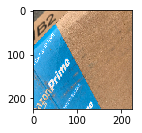

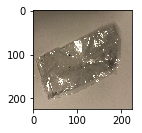

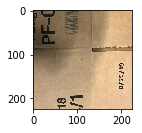

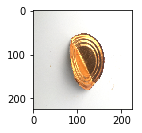

In [6]:
# Main

# train_files, train_labels = split_data(input_data_path, trash_type, shuffle_data, tvt, 'train')
# val_files, val_labels = split_data(input_data_path, trash_type, shuffle_data, tvt, 'val')
# test_files, test_labels = split_data(input_data_path, trash_type, shuffle_data, tvt, 'test')

# write_to_tfrecords(train_filename, train_files, train_labels, 'train')
# write_to_tfrecords(val_filename, val_files, val_labels, 'val')
# write_to_tfrecords(test_filename, test_files, test_labels, 'test')

read_from_tfrecords('train')